In [1]:
# 读取数据划分测试集训练集
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics  # sklearn 中评价指标函数库
from tqdm import tqdm

# 读书取数据
data = np.loadtxt("fm_dataset.csv", delimiter=",")

# 划分数据集
np.random.seed(0)
ratio = 0.8
split = int(len(data) * ratio)
# 数据划分方式：:split 按行， :-1按列取到倒数第二列 -1 取最后一列
x_train, x_test = data[:split, :-1], data[split:, :-1]
y_train, y_test = data[:split, -1], data[split:, -1]

# 特征数
feature_num = x_train.shape[1]
print('特征数：', feature_num)

特征数： 24


In [7]:
class FM:
    def __init__(self, feature_num, vector_dim):
        # vector_dim 代表公式中的k，为向量v的维度
        self.theta0 = 0.0  # 常数项部分
        self.theta = np.zeros(feature_num)  # 线性参数
        print(self.theta)
        self.v = np.random.normal(size=(feature_num, vector_dim))  # 双线性参数
        self.eps = 1e-6  # 精度参数

    def _logistic(self, x):
        return 1 / (1 + np.exp(-x))

    def pred(self, x):
        # 线性部分
        linear_term = self.theta0 + x @ self.theta
        # 双线性部分
        square_of_sum = np.square(x @ self.v)
        sum_of_square = np.square(x) @ np.square(self.v)
        # 预测
        y_pred = self._logistic(
            linear_term + 0.5 * np.sum(square_of_sum - sum_of_square, axis=1)
        )
        # 对数据进行剪枝，将其控制在 eps 到 1-eps 间，防止后续计算的梯度过大，
        # clip  控制传入数据的范围 ，若最小值 或最大值超出范围，则会用设定的min 和max 进行替换
        # a = np.array([1, 2, 3, 4, 5])
        # clipped_a = np.clip(a, 2, 4)
        # [2 2 3 4 4] 元数据的1和5 被替换为2，4
        y_pred = np.clip(y_pred, self.eps, 1 - self.eps)
        return y_pred

    def update(self, grad0, grad_theta, grad_v, lr):
        self.theta0 -= lr * grad0
        self.theta -= lr * grad_theta
        self.v -= lr * grad_v


# 超参数设置,包括学习率、训练轮数等
vector_dim = 16
learning_rate = 0.01
lbd = 0.05  # 正则化系数，防止过拟合
max_training_step = 200
batch_size = 32

# 初始化模型
np.random.seed(0)
model = FM(feature_num, vector_dim)


train_acc = []
test_acc = []
train_auc = []
test_auc = []
with tqdm(range(max_training_step)) as pbar:
    for epoch in pbar:
        st = 0
        while st < len(x_train):
            ed = min(len(x_train), st + batch_size)
            X = x_train[st:ed]
            Y = y_train[st:ed]
            st += batch_size
            # 进行预测
            y_pred = model.pred(X)
            # 计算交叉上损失
            cross_entropy = -Y * np.log(y_pred) - (1 - Y) * np.log(1 - y_pred)
            loss = np.sum(cross_entropy)
            # 计算损失函数对y的梯度，再根据链式法则得到总梯度
            grad_y = (y_pred - Y).reshape(-1, 1)
            # 计算 y对参数的梯度
            # 常数项
            grad0 = np.sum(grad_y * (1 / len(X) + lbd))
            # 线性项
            grad_theta = np.sum(grad_y * (X / len(X) + lbd * model.theta), axis=0)
            # 双线性项
            grad_v = np.zeros((feature_num, vector_dim))
            for i, x in enumerate(X):
                # 计算sum(x_i *v_i)
                xv = x @ model.v
                grad_vi = np.zeros((feature_num, vector_dim))
                for s in range(feature_num):
                    grad_vi[s] += x[s] * xv - (x[s] ** 2) * model.v[s]
                grad_v += grad_y[i] * grad_vi
            grad_v = grad_v / len(x) + lbd * model.v
            model.update(grad0, grad_theta, grad_v, learning_rate)

            pbar.set_postfix(
                {
                    "Epoch": epoch,
                    "loss": f"{loss:.4f}",
                    "训练准确率": train_acc[-1] if train_acc else None,
                    "测试准确率": test_acc[-1] if test_acc else None,
                }
            )
        # 计算预测的准确率和AUC
        # 预测准确率阈值设置为0.5
        y_train_pred = model.pred(x_train) >= 0.5
        acc = np.mean(y_train_pred == y_train)
        train_acc.append(acc)
        auc = metrics.roc_auc_score(y_train, y_train_pred)  # sklearn中AUC函数
        train_auc.append(auc)

        y_test_pred = model.pred(x_test) >= 0.5
        acc = np.mean(y_test_pred == y_test)
        test_acc.append(acc)
        auc = metrics.roc_auc_score(y_test, y_test_pred)
        test_auc.append(auc)
print(f"测试集准确率：{test_acc[-1]},\t测试集auc：{test_auc[-1]}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


100%|██████████| 200/200 [00:12<00:00, 15.85it/s, Epoch=199, loss=10.8604, 训练准确率=0.823, 测试准确率=0.785]

测试集准确率：0.785,	测试集auc：0.7119353697369973


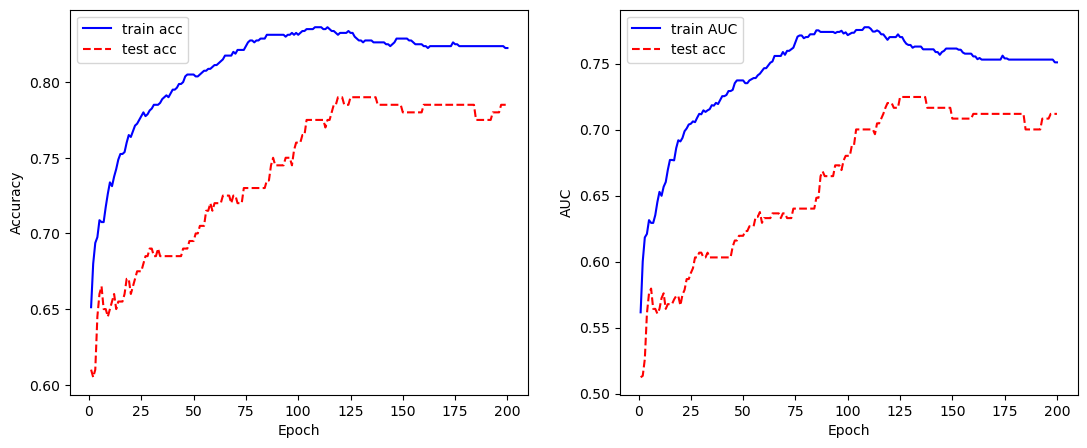

In [8]:
# 绘图
plt.figure(figsize=(13, 5))
x_plot = np.arange(len(train_acc)) + 1

plt.subplot(121)
plt.plot(x_plot, train_acc, c='b', label='train acc')
plt.plot(x_plot, test_acc, c='r', ls='--', label='test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(x_plot, train_auc, c='b', label='train AUC')
plt.plot(x_plot, test_auc, c='r', ls='--', label='test acc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()